### Linear Regression - Interpreting the result
In this notebook we use linear regression to predict the coefficients corresponding to the top eigenvectors of the measurements:
* TAVG: The average temperature for day/location. (TMAX + TMIN)/2
* TRANGE: The temperature range between the highest and lowest temperatures of the day. TMAX-TMIN.
* SNWD: The depth of the accumulated snow.

These 9 variables are the output variables that we aim to predict.

The 4 input variables we use for the regression are properties of the location of the station:
* latitude, longitude: location of the station.
* elevation: the elevation of the location above sea level.
* dist_coast: the distance of the station from the coast (in kilometers).

### Read and parst the data

In [1]:
import pickle
import pandas as pd
!ls *.pickle  # check 

stations_projections.pickle


In [2]:
#!curl -o "stations_projections.pickle" "http://mas-dse-open.s3.amazonaws.com/Weather/stations_projections.pickle"

In [3]:
data = pickle.load(open("stations_projections.pickle",'r'))
data.shape

(12140, 8)

In [4]:
data.head(1)

,station,TAVG_coeff,TRANGE_coeff,SNWD_coeff,latitude,longitude,elevation,dist_coast
0,USC00044534,"[3047.96236332, 1974.34852034, 150.560792408]","[-2903.63287861, -236.907267527, 147.021790682]","[0.19150300062, 0.187262808215, -0.0401379552536]",36.0042,-119.96,73.2,107.655


In [5]:
# break up the lists of coefficients separate columns
for col in [u'TAVG_coeff', u'TRANGE_coeff', u'SNWD_coeff']:
    for i in range(3):
        new_col=col+str(i+1)
        data[new_col]=[e[i] for e in list(data[col])]
    data.drop(labels=col,axis=1,inplace=True)
data.drop(labels='station',axis=1,inplace=True)
data.head(1)

,latitude,longitude,elevation,dist_coast,TAVG_coeff1,TAVG_coeff2,TAVG_coeff3,TRANGE_coeff1,TRANGE_coeff2,TRANGE_coeff3,SNWD_coeff1,SNWD_coeff2,SNWD_coeff3
0,36.0042,-119.96,73.2,107.655,3047.962363,1974.34852,150.560792,-2903.632879,-236.907268,147.021791,0.191503,0.187263,-0.040138


### Performing and evaluating the regression
As the size of the data is modest, we can perform the regression using regular python (not spark) running on a laptop. We use the library `sklearn`

In [6]:
from sklearn.linear_model import LinearRegression

### Coefficient of determination

Computed by calling the method `LinearRegression.score()`

The regression score comes under several names: "Coefficient of determination", $R^2$, "R squared score", "percentage of variance explained", "correlation coefficient". It is explained in more detail in [wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination).

Roughly speaking the $R^2$-score measures the fraction of the variance of the regression output variable that is explained by the prediction function. The score varies between 0 and 1. A score of 1 means that the regression function perfectly predicts the value of $y$. A score of 0 means that it does not predict $y$ at all.

#### Training score vs Test score
Suppose we fit a regression function with 10 features to 10 data points. We are very likely to fit the data perfectly and get a score of 1. However, this does not mean that our model truly explains the data. It just means that the number of training examples we are using to fit the model is too small. To detect this situation, we can compute the score of the model that was fit to the **training set**, on a **test set**. If the ratio between the test score and the training score is smaller than, say, 0.1, then our regression function probably over-fits the data.

#### Finding the importance of input variables
The fact that a regression coefficient is far from zero provides some indication that it is important. However, the size of these coefficients also depends on the scaling of the variables. A much more reliable way to find out which of the input variables are important is to compare the score of the regression function we get when using all of the input variables to the score when one of the variables is eliminated. This is sometimes called "sensitivity analysis"

In [7]:
# Compute score changes
def compute_scores(y_label,X_Train,y_Train,X_test,Y_test):
    lg = LinearRegression()
    lg.fit(X_Train,y_Train)

    train_score = lg.score(X_Train,y_Train)
    test_score = lg.score(X_test,Y_test)
    print('R-squared(Coeff. of determination): Train:%.3f, Test:%.3f\n' % (train_score,test_score))

    full=set(range(X_Train.shape[1]))
    for i in range(X_Train.shape[1]): # i = 0,1,2,3
        L=range(0,i)+range(i+1,X_Train.shape[1])  # fill in
        L.sort()
        r_train_X=X_Train[:,L]
        r_test_X=X_test[:,L]
        
        lg = LinearRegression()
        lg.fit(r_train_X,y_Train)
        r_train_score = lg.score(r_train_X,y_Train)
        r_test_score  = lg.score(r_test_X,Y_test)
        print "removed",data.columns[i],
        print "Score decrease: \tTrain:%5.3f" % (train_score-r_train_score),
        print "\tTest: %5.3f " % (test_score-r_test_score)

### Partition into training set and test set
By dividing the data into two parts, we can detect when our model over-fits. When over-fitting happens, the significance on the test set is much smaller than the significance on the training set.

In [8]:
from numpy.random import rand
N=data.shape[0]
train_i = rand(N)>0.5
test_i = ~train_i           # add by me
Train = data.ix[train_i,:]
Test  = data.ix[test_i,:]   # add by me
print data.shape,Train.shape,Test.shape

(12140, 13) (6151, 13) (5989, 13)


In [9]:
Train.head(1)

,latitude,longitude,elevation,dist_coast,TAVG_coeff1,TAVG_coeff2,TAVG_coeff3,TRANGE_coeff1,TRANGE_coeff2,TRANGE_coeff3,SNWD_coeff1,SNWD_coeff2,SNWD_coeff3
0,36.0042,-119.96,73.2,107.655,3047.962363,1974.34852,150.560792,-2903.632879,-236.907268,147.021791,0.191503,0.187263,-0.040138


In [10]:
from sklearn.cross_validation import train_test_split

train_X = Train.ix[:,:4].values
test_X=Test.ix[:,:4].values
input_names=list(data.columns[:4])

In [11]:
print train_X[0]
train_X.shape

[  36.0042 -119.96     73.2     107.655 ]


(6151, 4)

In [12]:
for target in ["TAVG","TRANGE","SNWD"]:
    for j in range(1,4):
        y_label = target+"_coeff"+str(j)
        train_y = Train[y_label]
        test_y = Test[y_label]
        lg = LinearRegression()
        lg.fit(train_X,train_y)

        print "\nTarget variable: ", y_label, '#'*40
        print "Coeffs: ",\
            ' '.join(['%s:%5.2f ' % (input_names[i],lg.coef_[i]) for i in range(len(lg.coef_))])
        
        compute_scores(y_label, train_X, train_y, test_X, test_y)


Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-154.22  longitude:-19.34  elevation:-0.69  dist_coast:-0.13 
R-squared(Coeff. of determination): Train:0.933, Test:0.929

removed latitude Score decrease: 	Train:0.609 	Test: 0.616 
removed longitude Score decrease: 	Train:0.068 	Test: 0.065 
removed elevation Score decrease: 	Train:0.129 	Test: 0.119 
removed dist_coast Score decrease: 	Train:0.003 	Test: 0.003 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-4.26  longitude: 7.34  elevation:-0.15  dist_coast: 0.48 
R-squared(Coeff. of determination): Train:0.602, Test:0.586

removed latitude Score decrease: 	Train:0.005 	Test: 0.008 
removed longitude Score decrease: 	Train:0.114 	Test: 0.118 
removed elevation Score decrease: 	Train:0.070 	Test: 0.064 
removed dist_coast Score decrease: 	Train:0.393 	Test: 0.378 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [1]:
%pylab inline
data_dir = "../Data/Weather/"

import pickle
STAT1,STAT1_description=pickle.load(open(data_dir+'/STAT_TAVG_RANGE.pickle','r'))

Populating the interactive namespace from numpy and matplotlib


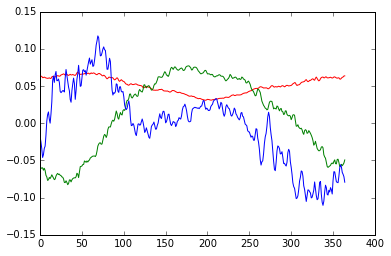

In [4]:
plot(STAT1['TAVG']['eigvec'][:,0],'r')
plot(STAT1['TAVG']['eigvec'][:,1],'g')
plot(STAT1['TAVG']['eigvec'][:,2],'b')

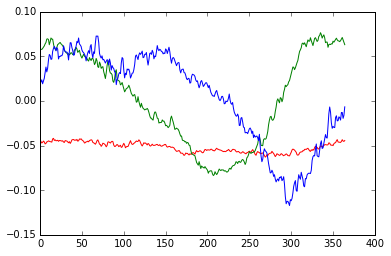

In [5]:
plot(STAT1['TRANGE']['eigvec'][:,0],'r')
plot(STAT1['TRANGE']['eigvec'][:,1],'g')
plot(STAT1['TRANGE']['eigvec'][:,2],'b')

### Interpretation
When we find a statistically significant coefficient, we want to find a rational explanation for the significance and for the sign of the corresponding coefficient. Please write a one line explanation for each of the following input/output pairs.

**Hint:** It is useful to go back to the figures depicting the shapes of the eigen-vectors.

```
Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-153.98  longitude:-19.21  elevation:-0.68  dist_coast:-0.13 
R-squared(Coeff. of determination): Train:0.931, Test:0.931

1. removed latitude Score decrease: 	Train:0.613 	Test: 0.612 
2. removed elevation Score decrease: 	Train:0.128 	Test: 0.121 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-5.33  longitude: 7.46  elevation:-0.14  dist_coast: 0.48 
R-squared(Coeff. of determination): Train:0.603, Test:0.585

3. removed longitude Score decrease: 	Train:0.115 	Test: 0.116 
4. removed dist_coast Score decrease: 	Train:0.393 	Test: 0.378 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude:-4.19  longitude:-2.64  elevation: 0.01  dist_coast: 0.07 
R-squared(Coeff. of determination): Train:0.420, Test:0.398

5. removed longitude Score decrease: 	Train:0.148 	Test: 0.164 
6. removed dist_coast Score decrease: 	Train:0.095 	Test: 0.082 

Target variable:  TRANGE_coeff1 ########################################
Coeffs:  latitude:25.00  longitude: 8.63  elevation:-0.36  dist_coast:-0.15 
R-squared(Coeff. of determination): Train:0.478, Test:0.435

7. removed elevation Score decrease: 	Train:0.127 	Test: 0.113 

Target variable:  TRANGE_coeff2 ########################################
Coeffs:  latitude:-32.63  longitude: 6.04  elevation:-0.02  dist_coast: 0.14 
R-squared(Coeff. of determination): Train:0.649, Test:0.642

8. removed latitude Score decrease: 	Train:0.461 	Test: 0.454 

Target variable:  SNWD_coeff1 ########################################
Coeffs:  latitude:147.72  longitude:21.54  elevation: 1.09  dist_coast:-0.88 
R-squared(Coeff. of determination): Train:0.232, Test:0.238

9. removed latitude Score decrease: 	Train:0.153 	Test: 0.155 
```

### Write your answers here

Consult the plots of the eigen-vectors. SNWD is available in an earlier notebook. The statistics for TRANGE and TAVG is in the file http://mas-dse-open.s3.amazonaws.com/Weather/STAT_TAVG_RANGE.pickle

For each of the following eigen-vectors, give a short verbal description
1. TAVG_coeff1: Average temperature across the year.
2. TAVG_coeff2: Difference in temperature between summer and winter.
3. TAVG_coeff3: Shift the pick (i.e. the hottest and coldest days) in the year induced by the Oceanic climate effect (depends most on longitude and distance from coast).
4. TRANGE_coeff1: Average temperature range across the year. 
5. TRANGE_coeff2: Difference in temperature range between summer and winter. 
6. SNWD_coeff1: Difference in snow depth between summer and winter. 

Once you have given a meaning to each of these eigen-vectors, explain the relation to the input variable. Short explanations are better than long ones.

Example:
Locations with high latitude are colder. 2. 3. 4. 5. 6. 7. 8. 9.

Keep your answers short. 

Example:

1. TAVG_Coeff1 captures the average temperature. Locations with higher lattitude are colder on average.

Answer:

1. TAVG_Coeff1 captures the average temperature across the year. Locations with higher lattitude are colder on average.
2. TAVG_Coeff1 also captures a little of the elevation effects on temperature, though not as much as the latitude. With a negative coefficient on elevation, the higher the elevation the lower temperature on average.
3. TAVG_Coeff2 captures the seasoning temperature which is affected by longitude. Locations with higher longitude have larger seasoning temperature differences.
4. TAVG_Coeff2 also captures the seasoning temperature due to the Oceanic climate effects, though not as much as the effects due to longitude. Locations that are further away from the coast have higher temperature difference between summer and winter.
5. TAVG_Coeff3 shifts the picks due to the longitude. However, with a negative coefficient which means summer and winter comes later with higer longitude.
6. TAVG_Coeff3 also captures shifts the picks due to the Oceanic climate effects. Locations with farther distance from the cost, summer and winter comes earlier.
7. TRANGE_Coeff1 captures the average temperature range. Locations with higher elevation have smaller temperature ranges. 
8. TRANGE_Coeff2 captures the temperature range difference between summer and winter. Locations with higher latitude have larger temperature range difference between summer and winter.
9. SNWD_Coeff1 captures the snow depth difference between summer and winter. Locations with higher latitude have higher snow depth difference. 
